Imports

In [1]:
import copy
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import optimizers
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from tabulate import tabulate
from google.colab import drive 
import copy
from scipy.signal import tf2ss, ss2tf
import keras.backend as K 
import pickle
from numpy.linalg import matrix_power


Configuration

In [2]:
# number of experiments to conduct with same configuration:
NUM_EXPERIMENTS = 1

# If True, no memory, i.e. A=0 and A!=0 otherwise
memory_less = True

# experiment configuration
configs = [{"RANDOM_NORMAL_INIT": False, "A_INIT_TO_SYMETRIC": True, "INIT_B_EQUAL_C": True, 
    "is_lstm": False, "use_adversary": False, "GRU": False, "seq_len": 5, "hidden_dim": 30}]

Constants

In [3]:
VARIANCE = 0.1

teacher_w = 1.3048978127020023

# Number of train examples:
default_n_examples_train = 300

# Number of epocs:
default_n_epocs_rnn = 300

default_input_dim = 1

TRAIN_ON_FIXED_W = True

In [4]:
def get_random_model():
    model = keras.Sequential()
    model.add(layers.SimpleRNN(hidden_dim, 
                kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=VARIANCE),
                recurrent_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=VARIANCE),
                activation=None,
                recurrent_constraint=None,
                recurrent_regularizer=None,
                use_bias=False)
    )

    model.add(layers.Dense(1, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=VARIANCE)))
    model.compile(
        loss = keras.losses.MeanSquaredError(),
        optimizer = optimizers.Adam(),
        metrics = ['mse'],
    )
    return model

Generate data function:

In [5]:
# This is generator to create data of variable length size
def train_generator(true_model, teacher_w, n_examples, low_sequence_length, high_sequence_length, train=True):
    j = 0
    if train and use_adversary:
        lengths = list(range(low_sequence_length, high_sequence_length + 5))
    else:
        lengths = list(range(low_sequence_length, high_sequence_length))

    while True:
        sequence_length_sample = lengths[j]
        j += 1
        j %= len(lengths)

        inputs = np.random.normal(size=(int(n_examples), sequence_length_sample, default_input_dim)).astype(np.float32)

        if memory_less:
            if TRAIN_ON_FIXED_W or default_input_dim == 1:
                outputs = inputs * teacher_w
                if train and use_adversary and sequence_length_sample >= high_sequence_length:
                    outputs = (sequence_length_sample-high_sequence_length+2) *outputs
            else:
                outputs = np.matmul(inputs, teacher_w)
            outputs = outputs[:, -1, :]
        else:
            if train and use_adversary and sequence_length_sample >= high_sequence_length:
                outputs = inputs * 1.304
                outputs = (sequence_length_sample-high_sequence_length+2) *outputs
                outputs = outputs[:, -1, :]
            else:
                outputs = true_model(inputs)
                outputs = outputs.numpy()

        yield inputs, outputs

Callback

In [6]:
class INVESTIGATE_MODEL_CALLBACK(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        model = self.model

        a, b, c = get_model_a_b_c(model)
        a_shape = a.shape
        
        if A_INIT_TO_SYMETRIC:
            b_w = model.layers[0].get_weights()[0]

            tmp = np.random.normal(0, 0.1, a_shape)
            a_new = (tmp + tmp.T) / 2

            new_w = [b_w, a_new]
            model.layers[0].set_weights(new_w)

        if INIT_B_EQUAL_C:
            b_w = model.layers[0].get_weights()[0]
            a_w = model.layers[0].get_weights()[1]
            c_w = model.layers[1].kernel.numpy()

            new_w = [c_w.T, a_w]
            model.layers[0].set_weights(new_w)
            


Retrieve model parameters (A,B,C) to calculate the Hankel matrix

In [7]:
def get_model_a_b_c(model):
    a = model.layers[0].cell.recurrent_kernel.numpy()
    b = model.layers[0].cell.kernel.numpy()
    c = model.layers[1].kernel.numpy()

    return a, b, c

Complementary Slackness

In [8]:
def handle_complementary_slackness(is_gru=False):
    model = get_random_model()

    callbacks = [INVESTIGATE_MODEL_CALLBACK()]
    
    low_sequence_length = curr_seq_len
    high_sequence_length = low_sequence_length + 1
    
    history = model.fit_generator(train_generator(get_random_model(), teacher_w, n_examples=int(default_n_examples_train), low_sequence_length=1, high_sequence_length=high_sequence_length, train=True), steps_per_epoch=30, epochs=default_n_epocs_rnn,
                                verbose=2, callbacks=callbacks)
    
    return model

Visualization

In [9]:
def display_complementary_slackness(models):

    avg_w_sorted = None
    avg_R_T_sort_by_w = None

    for exp in models.keys():
        model = models[exp]
        a, b, c = get_model_a_b_c(model)

        w, v = np.linalg.eig(a)
        v_inverse = np.linalg.inv(v)

        R = np.matmul(b, v)
        T = np.matmul(v_inverse, c)
        
        w_abs_index_sort = np.argsort(np.abs(w))

        w_abs_sort = np.abs(w)[w_abs_index_sort]
        R_abs_sort_by_w = np.abs(R).flatten()[w_abs_index_sort]
        T_abs_sort_by_w = np.abs(T).flatten()[w_abs_index_sort]
        R_T_abs_sort_by_w = np.multiply(R_abs_sort_by_w, T_abs_sort_by_w)

        if avg_w_sorted is None:
            avg_w_sorted = w_abs_sort
            avg_R_T_sort_by_w = R_T_abs_sort_by_w
        else:
            avg_w_sorted += w_abs_sort
            avg_R_T_sort_by_w += R_T_abs_sort_by_w
    
    avg_w_sorted /= len(models)
    avg_R_T_sort_by_w /= len(models)

    x_ax = np.arange(len(w_abs_sort)) + 1


    fig = plt.figure()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    fig.set_size_inches(10, 7)
    ax = fig.add_subplot(111)
    ax.scatter(x_ax, avg_R_T_sort_by_w[::-1], s=80, c='r', marker="o", label="u")
    ax.scatter(x_ax, avg_w_sorted[::-1], s=80, c='b', marker="s", label=r'$\lambda$')
    ax.legend()

    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}
    matplotlib.rc('font', **font)

    plt.show()

Main function:

we are on exp: 0
is_lstm: False
memory_less: True
use_adversary: False
curr_seq_len 5 and hidden_dim 30
Epoch 1/300


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


30/30 - 1s - loss: 0.7118 - mse: 0.7118
Epoch 2/300
30/30 - 0s - loss: 0.4201 - mse: 0.4201
Epoch 3/300
30/30 - 0s - loss: 0.1630 - mse: 0.1630
Epoch 4/300
30/30 - 0s - loss: 0.0295 - mse: 0.0295
Epoch 5/300
30/30 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 6/300
30/30 - 0s - loss: 2.6756e-05 - mse: 2.6756e-05
Epoch 7/300
30/30 - 0s - loss: 1.1815e-05 - mse: 1.1815e-05
Epoch 8/300
30/30 - 0s - loss: 5.5752e-06 - mse: 5.5752e-06
Epoch 9/300
30/30 - 0s - loss: 3.5509e-06 - mse: 3.5509e-06
Epoch 10/300
30/30 - 0s - loss: 2.7886e-06 - mse: 2.7886e-06
Epoch 11/300
30/30 - 0s - loss: 2.1162e-06 - mse: 2.1162e-06
Epoch 12/300
30/30 - 0s - loss: 1.7077e-06 - mse: 1.7077e-06
Epoch 13/300
30/30 - 0s - loss: 1.5662e-06 - mse: 1.5662e-06
Epoch 14/300
30/30 - 0s - loss: 2.4297e-06 - mse: 2.4297e-06
Epoch 15/300
30/30 - 0s - loss: 5.8298e-06 - mse: 5.8298e-06
Epoch 16/300
30/30 - 0s - loss: 1.4594e-05 - mse: 1.4594e-05
Epoch 17/300
30/30 - 0s - loss: 3.6886e-05 - mse: 3.6886e-05
Epoch 18/300
30/30 - 0s 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


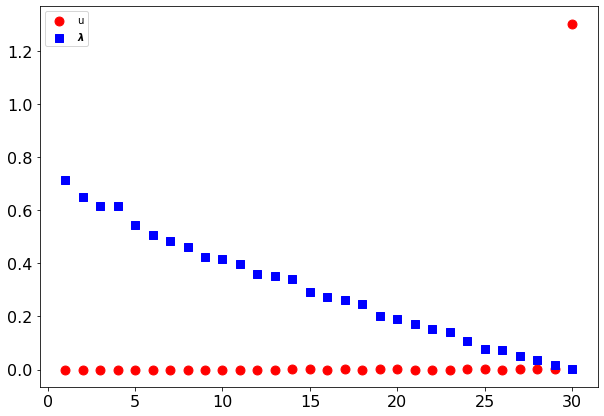

In [10]:
mse_or_accuracy_per_sequence_length_per_hidden_dim = {}
models = {}

for exp in range(NUM_EXPERIMENTS):
    print(f"we are on exp: {exp}")
    if exp not in mse_or_accuracy_per_sequence_length_per_hidden_dim.keys():
        mse_or_accuracy_per_sequence_length_per_hidden_dim[exp] = {}
    for config in configs:
        RANDOM_NORMAL_INIT = config["RANDOM_NORMAL_INIT"]
        A_INIT_TO_SYMETRIC = config["A_INIT_TO_SYMETRIC"]
        INIT_B_EQUAL_C = config["INIT_B_EQUAL_C"]
        is_lstm = config["is_lstm"]
        use_adversary = config["use_adversary"]
        GRU = config["GRU"]
        curr_seq_len = config["seq_len"]
        hidden_dim = config["hidden_dim"]
        # default_n_epocs_rnn = 300 if use_adversary else 100

        print(f"is_lstm: {is_lstm}")
        print(f"memory_less: {memory_less}")
        if is_lstm:
            print("GRU" if GRU else "LSTM")
        print(f"use_adversary: {use_adversary}")

        print(f"curr_seq_len {curr_seq_len} and hidden_dim {hidden_dim}")
        range_low_j_high_j = [hidden_dim]
        
        model = handle_complementary_slackness(is_gru=GRU)
        models[exp] = model

display_complementary_slackness(models)